# **Pose Detection For Weight Lifting and Exercise**

# SETUP

## Import Dependencies

In [3]:
# !pip install numpy
# !pip install pandas
# !pip install ultralytics
# !pip install matplotlib
# !pip install opencv-python
# !pip install pillow
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install tqdm

In [4]:
import numpy as np
import pandas as pd
import random

# YOLO
import ultralytics
from ultralytics import YOLO
import ultralytics.utils as plot


# Images
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from PIL import ImageFont
from PIL.ImageDraw import Draw

# Torch
import torch
from torch import nn
import torchvision
import torchvision.transforms.v2 as T

# Files
import os
from os.path import join, split
from glob import glob

# Others
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [5]:
torch.cuda.is_available()

True

In [6]:
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"OpenCV Version: {cv2.__version__}")

Numpy Version: 1.26.4
PyTorch Version: 2.4.0.dev20240413+cu121
Pandas Version: 2.2.2
OpenCV Version: 4.9.0


## CONFIGURATION

In [7]:
class CFG:
    path = "./"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    random_seed = 42

print(f"DEVICE: {CFG.device}")

DEVICE: cuda


## REPRODUCIBILITY

In [8]:
torch.manual_seed(CFG.random_seed) # PyTorch
np.random.seed(CFG.random_seed) # NumPy
random.seed(CFG.random_seed) # Python

# LOAD MODEL

In [9]:
model = YOLO('yolov8n-pose.pt', verbose=False) 

In [10]:
def preprocess_img(image:np.array,
                   transform = T.Resize((640,640))):
    image = image if image.shape[0] == 3 else image.transpose(2,0,1)
    if image.max() > 1.0:
        image = image/255.0
    ch, h, w = image.shape
    image = image.reshape(1, ch, h, w)
    return transform(torch.Tensor(image))


# DETECTION

In [11]:
def detect(img):
    if img.shape[0] ==3:
        _,h,w = img.shape
    else:
        h,w,_ = img.shape

    revert_transform = T.Resize((h,w))

    result = model.predict(preprocess_img(img), conf=0.75)[0]


    widths = [int(i[2]) for i in result.boxes.xywh]
    heights = [int(i[3]) for i in result.boxes.xywh]
    areas = [int(widths[i]*heights[i]) for i in range(len(widths))]


    for i,r in enumerate(list(result)):
        if areas[i] == max(areas):
            im_array = r.plot(kpt_line=True, kpt_radius=10)
            im_array = revert_transform(torch.Tensor(im_array.transpose(2,0,1).reshape(1,3,640,640))).cpu().numpy().astype(np.uint8).squeeze().transpose(1,2,0)
            im_array = im_array[:,:,::-1]

            keypoints = r.keypoints.xy

    try:
        return im_array, keypoints[0]
    except:
        return img[:,:,::-1], None

In [12]:
def scale(x_scale, y_scale, keypoint):
    x = keypoint[0]*x_scale
    y = keypoint[1]*y_scale
    return x.cpu().numpy(),y.cpu().numpy()

In [13]:
def arm_angle(keypoints, h, w):
    x_scale, y_scale = w/640, h/640
    Lshoulder = scale(x_scale, y_scale, keypoints[5])
    Rshoulder = scale(x_scale, y_scale, keypoints[6])
    Lelbow = scale(x_scale, y_scale, keypoints[7])
    Relbow = scale(x_scale, y_scale, keypoints[8])
    Lhand = scale(x_scale, y_scale, keypoints[9])
    Rhand = scale(x_scale, y_scale, keypoints[10])

    LAngle = np.arctan2(Lhand[1]-Lelbow[1], Lhand[0]-Lelbow[0]) - np.arctan2(Lshoulder[1]-Lelbow[1], Lshoulder[0]-Lelbow[0])
    LAngle = np.abs(LAngle*180.0/np.pi)

    RAngle = np.arctan2(Rhand[1]-Relbow[1], Rhand[0]-Relbow[0]) - np.arctan2(Rshoulder[1]-Relbow[1], Rshoulder[0]-Relbow[0])
    RAngle = np.abs(RAngle*180.0/np.pi)

    return LAngle, RAngle
    
    

In [14]:
def camera():
    cap = cv2.VideoCapture(0)

    while(True): 
        ret, frame = cap.read() 
        out, kp = detect(frame)
        out = np.ascontiguousarray(out, dtype=np.uint8)
        out = out[:,:,::-1]
        out = Image.fromarray(out)
        draw = Draw(out)
        draw.rectangle((0,0,100,80), fill=(255,255,255))
        if kp is not None:
            LAngle, RAngle = arm_angle(kp, frame.shape[0], frame.shape[1])
            draw.text((10, 10), f"Left Arm: {round(LAngle)}", fill =(0, 0, 255))
            draw.text((10, 50), f"Right Arm: {round(RAngle)}", fill =(0, 0, 255))
            
        cv2.imshow('frame', np.array(out)) 
        # Close Window with 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break
    
    cap.release() 
    cv2.destroyAllWindows() 

In [15]:
!pip3 install --pre torch torchvision  --index-url https://download.pytorch.org/whl/nightly/cu121

Looking in indexes: https://download.pytorch.org/whl/nightly/cu121


In [16]:
camera()


0: 640x640 1 person, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 

# INFERENCE

In [17]:
def showImage(path, inf=True):
    with Image.open(path) as img:
        img = np.array(img)/255.0
    if inf:
        img,_ = detect(img)
        img = img[:,:,::-1]
    plt.imshow(img)
    plt.axis(False)
    plt.show()

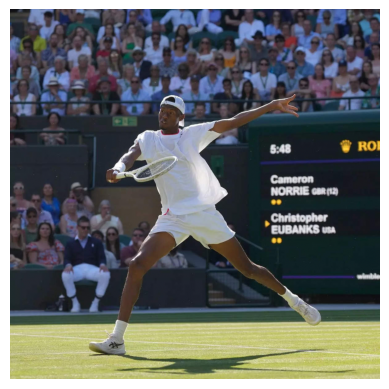


0: 640x640 2 persons, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


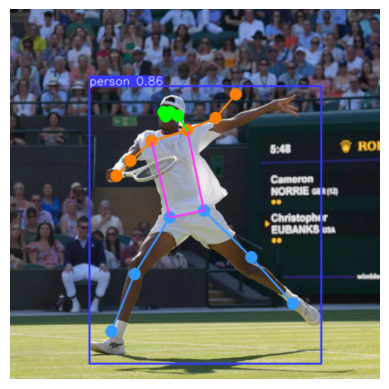

In [18]:
showImage("notebook_images\\test_img.jpg", False)
showImage("notebook_images\\test_img.jpg")

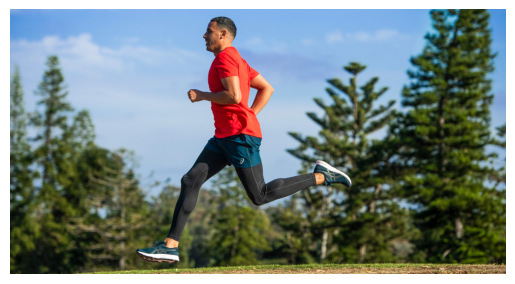


0: 640x640 1 person, 22.0ms
Speed: 1.0ms preprocess, 22.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


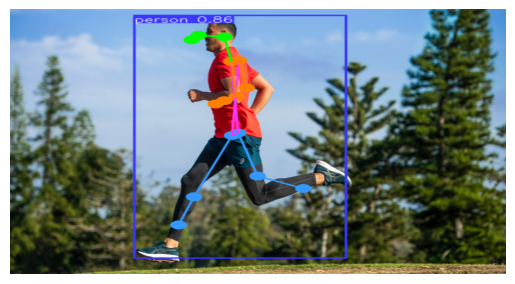

In [19]:
showImage("notebook_images\\test2.jpg",False)
showImage("notebook_images\\test2.jpg")

In [20]:
with Image.open("notebook_images/test_img.jpg") as img:
        img = np.array(img)/255.0

In [21]:
results = model(preprocess_img(img))[0]


0: 640x640 6 persons, 31.5ms
Speed: 1.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [22]:
results

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: ultralytics.engine.results.Keypoints object
masks: None
names: {0: 'person'}
obb: None
orig_img: array([[[ 17,  16,  21],
        [ 17,  16,  21],
        [ 17,  15,  21],
        ...,
        [ 43,  40,  41],
        [ 46,  35,  38],
        [ 49,  34,  39]],

       [[ 17,  16,  21],
        [ 17,  16,  22],
        [ 17,  15,  21],
        ...,
        [ 50,  46,  47],
        [ 52,  41,  45],
        [ 56,  41,  46]],

       [[ 17,  15,  21],
        [ 17,  15,  21],
        [ 17,  15,  21],
        ...,
        [ 50,  46,  48],
        [ 54,  43,  47],
        [ 59,  43,  48]],

       ...,

       [[189, 190, 124],
        [189, 190, 124],
        [188, 189, 123],
        ...,
        [201, 199, 140],
        [200, 198, 139],
        [197, 195, 136]],

       [[197, 198, 132],
        [195, 196, 130],
        [192, 193, 127],
        ...,
        [205, 203, 144],

In [23]:
results.keypoints.xy[0]

tensor([[128.2257, 381.9189],
        [133.0380, 378.5946],
        [123.9782, 377.9684],
        [139.7311, 382.5161],
        [116.5610, 380.9983],
        [149.2430, 403.6476],
        [106.8291, 404.4739],
        [160.9688, 434.9263],
        [ 99.8564, 438.7225],
        [157.6476, 447.7195],
        [106.7303, 447.3967],
        [146.7388, 454.0280],
        [117.1508, 454.4224],
        [153.5439, 459.1477],
        [106.5090, 458.1019],
        [153.9651, 512.2618],
        [108.6408, 511.3971]], device='cuda:0')

In [24]:
x,y = results.keypoints.xy[1][12]
x, y = x*1.875, y*1.875

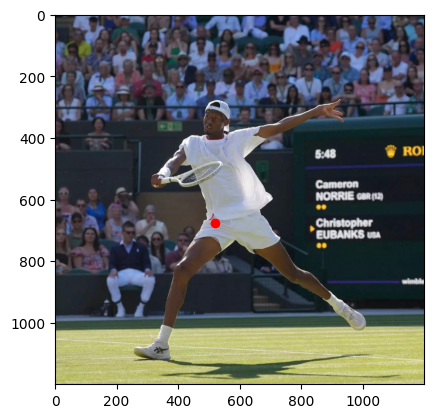

In [25]:
plt.imshow(img)
plt.plot(x.cpu().numpy(), y.cpu().numpy(), 'ro')
plt.show()

In [26]:
def arm_lift_angle(keypoints, h, w):
    x_scale, y_scale = w/640, h/640
    Lshoulder = scale(x_scale, y_scale, keypoints[5])
    Rshoulder = scale(x_scale, y_scale, keypoints[6])
    Lhand = scale(x_scale, y_scale, keypoints[9])
    Rhand = scale(x_scale, y_scale, keypoints[10])

    Lhip = scale(x_scale, y_scale, keypoints[11])
    Rhip = scale(x_scale, y_scale, keypoints[12])

    LAngle = np.arctan2(Lhand[1]-Lshoulder[1], Lhand[0]-Lshoulder[0]) - np.arctan2(Lhip[1]-Lshoulder[1], Lhip[0]-Lshoulder[0])
    LAngle = np.abs(LAngle*180.0/np.pi)

    RAngle = np.arctan2(Rhand[1]-Rshoulder[1], Rhand[0]-Rshoulder[0]) - np.arctan2(Rhip[1]-Rshoulder[1], Rhip[0]-Rshoulder[0])
    RAngle = np.abs(RAngle*180.0/np.pi)

    return LAngle, RAngle

In [27]:
class raises:
    def  __init__(self):
        self.state = -1
        self.reps = 0
    
    # !state ensures doesn't change from both to one if moving arms slightly out of sync

    def raises(self, L, R):
        '''
        LAT RAISE STATE

        0 - both unextended
        1 - R unextended
        2 - L unextended
        3 - R extended
        4  - L extended
        5 - both extended
    '''
        if L < 30 and R < 30: # Both Bent
            return 5
        if L > 80 and R > 80: # Both Extend
            return 0
        if L > 80 and self.state != 0: # Left Extend
            return 2
        if R > 80 and self.state != 0: # Right Extend
            return 1
        if L < 30 and self.state != 5: # Left Bent
            return 4
        if R <30 and self.state != 5: # Right Bent
            return 3
        return self.state

    def bentArm(self, RArm, LArm):
        if RArm <165 or LArm <165:
            self.state = 0

    def countLatRaise(self, prev, curr):
        '''
        LAT RAISE COUNTER

        0 - none
        1 - rep

        '''

        if curr == 4: # Left Bent
            if prev == 0 or prev == 2: # If previously extended
                return 1
        if curr == 3: # Right Bent
            if prev == 0 or prev == 1: # If previously extended
                return 1
        if curr == 5 and prev == 0: # Both Bent; Previously both extended
                return 1
        
        return 0
    
    def run(self, LAngle, RAngle, LArm, RArm):
        self.bentArm(RArm, LArm)

        new = self.raises(LAngle, RAngle)
        output = self.countLatRaise(self.state, new)
        if output:
            self.reps += 1
        self.state = new

In [28]:
from PIL import ImageFont

In [29]:
cap = cv2.VideoCapture(0)

while(True): 
    ret, frame = cap.read() 
    out, kp = detect(frame)
    out = np.ascontiguousarray(out, dtype=np.uint8)
    out = out[:,:,::-1]
    out = Image.fromarray(out)
    draw = Draw(out)
    draw.rectangle((0,0,100,80), fill=(255,255,255))
    font = ImageFont.truetype("arial.ttf", 20)
    if kp is not None:
        LAngle, RAngle = arm_angle(kp, frame.shape[0], frame.shape[1])
        LArm, RArm = arm_lift_angle(kp, frame.shape[0], frame.shape[1])
        draw.text((10, 10), f"Left Arm: {round(LArm)}", font=font, fill =(0, 0, 255))
        draw.text((10, 50), f"Right Arm: {round(RArm)}", font=font, fill =(0, 0, 255))
        
    cv2.imshow('frame', np.array(out)) 
    # Close Window with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 


0: 640x640 1 person, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x